In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.17.0


In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

print("슝=3")

슝=3


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

print("슝=3")

슝=3


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

print("슝=3")

슝=3


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_causality_mask(tgt)
    dec_enc_mask = generate_padding_mask(tgt)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

print("슝=3")

슝=3


In [ ]:
import os
data_dir = os.getenv('HOME')
kor_path = "korean-english-park.train.ko"
eng_path = "korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    corpus_pairs = list(zip(kor, eng))
    unique_pairs = list(set(corpus_pairs))
    cleaned_kor, cleaned_eng = zip(*unique_pairs)
    cleaned_corpus = list(zip(cleaned_kor, cleaned_eng))
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z가-힣\s\.\,\!\?]', '', sentence)
    sentence = re.sub(r'([\.|\,|\!|\?])', r' \1 ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence

In [ ]:
import tempfile
import os
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # 모델 저장 경로가 없다면 생성
    model_dir = "tk_model"
    os.makedirs(model_dir, exist_ok=True)  # tk_model 디렉터리 생성

    # 임시 파일을 사용해 SentencePiece 학습
    with tempfile.NamedTemporaryFile(delete=False, mode='w', encoding='utf-8') as temp_file:
        for sentence in corpus:
            temp_file.write(sentence + "\n")
        temp_file_path = temp_file.name

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.train(
        input=temp_file_path,
        model_prefix=f"{model_dir}/{lang}_tokenizer",
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id
    )

    # SentencePiece 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_dir}/{lang}_tokenizer.model")

    return tokenizer


SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")


True

In [ ]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

max_length = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm(range(len(kor_corpus))):
    kor_tk_corpus = ko_tokenizer.encode(kor_corpus[idx])
    eng_tk_corpus = ko_tokenizer.encode(eng_corpus[idx])

    # 한국어만 50개 이하로 설정하면 7만개정도의 데이터, 둘다 설정하면 4만개정도가 나온다
    if len(kor_tk_corpus) < max_length+1 and len(eng_tk_corpus) < max_length+1:
        src_corpus.append(kor_tk_corpus)
        tgt_corpus.append(eng_tk_corpus)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')
print(enc_train.shape)


  0%|          | 0/78968 [00:00<?, ?it/s]

(50044, 50)


In [ ]:
"""
# 하이퍼파라미터 설정
n_layers = 2  # 지시사항에 따라 2개의 레이어
d_model = 256  # 모델의 차원
n_heads = 8  # 어텐션 헤드의 개수
d_ff = 512  # 피드포워드 네트워크의 차원
src_vocab_size = 8000  # 소스(입력) 어휘 사전 크기
tgt_vocab_size = 8000  # 타겟(출력) 어휘 사전 크기
pos_len = 1000  # 최대 위치 길이 (포지셔널 인코딩에 사용)
dropout_rate = 0.1  # 드롭아웃 비율
"""
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 1024
src_vocab_size = tgt_vocab_size = 20000
pos_len = 256

transformer = Transformer(
    n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len)

# Transformer 모델 선언
transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    pos_len=pos_len,
    dropout=dropout_rate,
    shared=True  # 디코더 임베딩과 출력 레이어 사이의 가중치 공유
)
print("Transformer 모델이 성공적으로 선언되었습니다.")

Transformer 모델이 성공적으로 선언되었습니다.


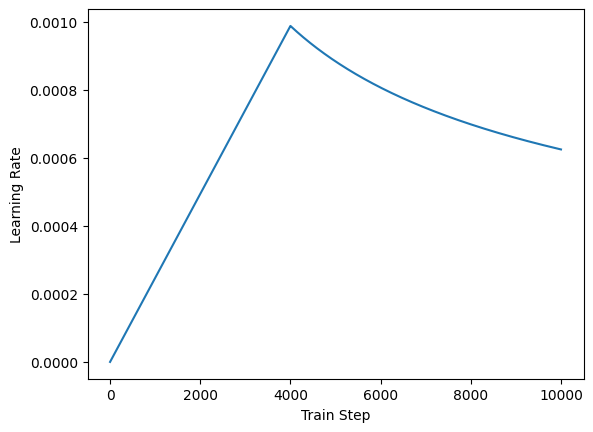

In [ ]:
import tensorflow as tf

# Custom Learning Rate Scheduler (논문에서 제안된 방식)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)  # step_num^-0.5
        arg2 = step * (self.warmup_steps ** -1.5)  # step_num * warmup_steps^-1.5
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 하이퍼파라미터 설정
d_model = 256  # 모델 차원
warmup_steps = 4000  # 논문에서 사용된 warmup 스텝

# 학습률 스케줄러 선언
learning_rate = CustomSchedule(d_model, warmup_steps)

# Adam Optimizer 선언 (논문에서 사용된 파라미터와 동일하게 설정)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,  # Custom learning rate schedule
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# 학습률 스케줄러 테스트 (옵셔널)
import matplotlib.pyplot as plt

steps = tf.range(1, 10000, dtype=tf.float32)
lrs = [learning_rate(step) for step in steps]
plt.plot(steps, lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    # gold: 실제 정답 (목표 데이터의 시프트된 버전)
    gold = tgt[:, 1:]

    # 입력 데이터에 알맞은 마스크 생성
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 손실(loss)에 대해 tf.GradientTape()를 사용하여 학습
    with tf.GradientTape() as tape:
        # 모델에 데이터를 전달하여 예측값 계산
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)

        # 손실 함수 계산 (gold와 모델의 예측값 비교)
        loss = loss_function(gold, predictions[:, :-1])

    # 그라디언트 계산
    gradients = tape.gradient(loss, model.trainable_variables)

    # Adam Optimizer를 사용해 모델 파라미터 업데이트
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data,
                        square=True,
                        vmin=0.0, vmax=1.0,
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input,
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
from tqdm import tqdm_notebook
import random

BATCH_SIZE = 64
EPOCHS = 3

# 번역 예시
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        # train_step 함수 호출, BATCH_SIZE 만큼 데이터를 배치로 나눠 처리
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        # 현재 Epoch과 손실 값을 tqdm 진행 바에 표시
        t.set_description_str(f'Epoch {epoch + 1}')
        t.set_postfix_str(f'Loss {total_loss.numpy() / (batch + 1):.4f}')

    # 번역 예제 출력
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)


<ipython-input-63-fedb78491709>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/782 [00:00<?, ?it/s]

ValueError: in user code:

    File "<ipython-input-59-5b44cb97605a>", line 7, in train_step  *
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    File "<ipython-input-10-a1f8098a58fa>", line 14, in generate_masks  *
        dec_mask = generate_causality_mask(tgt)
    File "<ipython-input-10-a1f8098a58fa>", line 9, in generate_causality_mask  *
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/dtensor/python/api.py", line 64, in call_with_layout
        return fn(*args, **kwargs)

    ValueError: Shape must be rank 1 but is rank 3 for '{{node ones}} = Fill[T=DT_FLOAT, index_type=DT_INT32](ones/packed, ones/Const)' with input shapes: [2,64,50], [].
